In [ ]:
%matplotlib inline
import numpy as np
from queue import LifoQueue
from random import shuffle, uniform, random, choice
import matplotlib.pyplot as plt
import math 


class grid:
    def __init__(self, N, S, F, p):
        
        assert N > 2
        assert S[0] < N
        assert S[1] < N
        assert F[0] < N
        assert F[1] < N

        assert S[0] > 0
        assert S[1] > 0
        assert F[0] > 0
        assert F[1] > 0

        self.N = N

        self.grid = np.zeros((N, N), dtype=np.int32)
        
        ## Surround the grid with obstacles
        self.grid[0, :] = 1
        self.grid[N - 1, :] = 1
        self.grid[:, 0] = 1
        self.grid[:, N - 1] = 1

        obstacle_free_points = {S, F}

        ### Fill the grid with obstacles. 
        ### An obstacle at position (x,y) -> grid[x,y]=1
        ### Ensure there is a path from S to F

        #create a path from S to F randomly
        path = [S]
        adjacents = self.adjacent(S)
        curr_node = choice(adjacents)
        path.append(curr_node)
        while curr_node != F:
            adjacents = self.adjacent(curr_node)
            curr_node = choice(adjacents)
            path.append(curr_node)
        
        #Remove the circles from the path
        j = 0
        while j != len(path):
            k = len(path)-1
            while path[j] != path[k]:
                k -= 1
            path = path[0:j] + path[k:len(path)] 
            j += 1  
        
        #fill the remaining graph with obstacles with probability p
        for r in range(1,N-1):
            for c in range(1, N-1):
                if not(r == S[0] and c == S[1]) and not(r == F[0] and c == F[1]) and (random() < p) and (r,c) not in path:
                    self.grid[r,c]=1
        
        for i in path:
            self.grid[i] = 0
                

    def adjacent(self, node):
        adjacent_nodes = []
        for n in (node[0] - 1, node[1]), (node[0] + 1, node[1]), (node[0], node[1] - 1), (node[0], node[1] + 1):
            if self.grid[n] == 0:
                adjacent_nodes.append(n)

        return adjacent_nodes
        
    #function to check if there is a path from s to f.

    def path_exist(self, s, f, N):
        # Mark all the vertices as not visited 
        visited=[[0 for i in range(N)]for j in range(N)]
        # Create a queue for BFS 
        queue = [] 
        # Mark the source node as  
        # visited and enqueue it 
        queue.append(s) 
        visited[s[0]][s[1]] = 1
        while queue: 
            # Dequeue a vertex from queue
            s = queue.pop(0) 
  
            # Get all adjacent vertices of the 
            # dequeued vertex s. If a adjacent 
            # has not been visited, then mark it 
            # visited and enqueue it 
            adjacents = self.adjacent(s)
            for i in adjacents:
                if (visited[i[0]][i[1]] == 0):
                    queue.append(i)
                    visited[i[0]][i[1]] = 1
                    if i == f:
                        return True
        return False
         

        

    def draw_map(self, S=None, F=None, path=None):

        image = np.zeros((self.N, self.N, 3), dtype=int)
        
        image[self.grid == 0] = [255, 255, 255]
        image[self.grid == 1] = [0, 0, 0]
        if S:
            image[S] = [50, 168, 64]
        if F:
            image[F] = [168, 50, 50]
        if path:
            for n in path[1:-1]:
                image[n] = [66, 221, 245]

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()


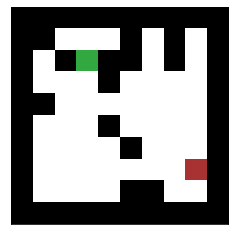

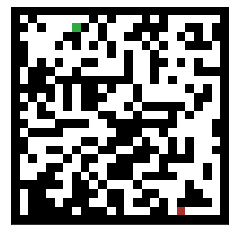

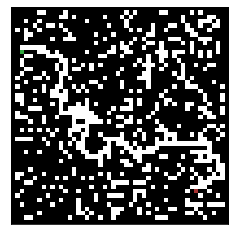

In [ ]:
# show different grid sizes with different obstacle densities

for N, S, F, p in (10, (2, 3), (7, 8), .3), (25, (2, 7), (23, 19), .5), (50, (10, 2), (42, 42), .8):

    map = grid(N, S, F, p)
    map.draw_map(S, F)


In [ ]:
class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


#give g, h_algorithm = 0, h=0
#                      1, h=manhattan(n)
#                      2, h=euclidian(n)

class pathfinder:
    def __init__(self, S, F, grid, g, h_algorithm):
        self.S = S  ## S is the starting point - a tuple (x,y)
        self.F = F  ## F is the goal
        self.grid = grid ## A grid object (from A)
        self.vis = visualization(S, F)
        self.path = []
        (self.path, self.closed_list) = self.find_path(self.grid, self.S, self.F, g, h_algorithm)
        
    def manhattan(self, child, end_node):
        return abs(child.position[0] - end_node.position[0]) + abs(child.position[1] - end_node.position[1])

    def euclidian(self, child, end_node):
        return np.sqrt(((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2))



    ### Fill the path list with the coordinates of each point in the path from S to F

    def find_path(self, grid, start, end, g, h_algorithm):
    #Returns a list of tuples as a path from the given start to the given end in the given grid
        # Create start and end node
        start_node = Node(None, start)
        start_node.g = start_node.h = start_node.f = 0
        end_node = Node(None, end)
        end_node.g = end_node.h = end_node.f = 0

        # Initialize both open and closed list
        open_list = []
        closed_list = []
        open_list_positions = []
        closed_list_positions = []

        # Add the start node
        open_list.append(start_node)
        open_list_positions.append(start_node.position)
        # Loop until you find the end
        while len(open_list) > 0:
            # Get the current node
            current_node = open_list[0]
            current_index = 0
            for index, item in enumerate(open_list):
                if item.f < current_node.f:
                    current_node = item
                    current_index = index

            # Pop current off open list, add to closed list
            open_list.pop(current_index)
            open_list_positions.pop(current_index)
            closed_list.append(current_node)
            closed_list_positions.append(current_node.position)

            # Found the goal
            if current_node == end_node:
                path = []
                current = current_node
                while current is not None:
                    path.append(current.position)
                    current = current.parent
                return (path[::-1], closed_list_positions) # Return reversed path and closed list

            # Generate children
            children = []
            for new_child in grid.adjacent(current_node.position): # Adjacent squares
                
                # Create new node
                new_node = Node(current_node, new_child)

                # Append
                children.append(new_node)

            # Loop through children
            for child in children:

                # Child is on the closed list
                if child in closed_list:
                    continue

                # Create the f, g, and h values
                child.g = current_node.g + g
                if h_algorithm == 1:
                    child.h = self.manhattan(child, end_node)
                if h_algorithm == 2:
                    child.h = self.euclidian(child, end_node)
                if h_algorithm == 0:
                    child.h = 0
                child.f = child.g + child.h

                # Child is already in the open list
                if child in open_list:
                    check = True
                    for open_node in open_list:
                        if child == open_node and child.g < open_node.g:
                            check = False
                            break                 
                    if check:        
                        continue
                    else:
                        open_list.remove(open_node)
                        open_list_positions.remove(open_node.position)

                # Add the child to the open list
                open_list.append(child)
                open_list_positions.append(child.position)
                
            self.vis.draw_step(map, open_list_positions, closed_list_positions) #draw next frame
            
        self.vis. add_path(path)  


    def get_path(self):
        return self.path
    
    def get_closed_list(self):
        return self.closed_list


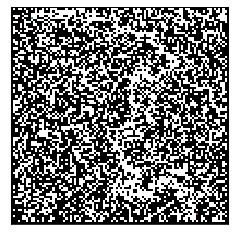

Dikstra


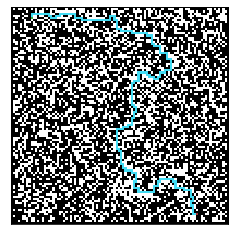

A* with manhattan


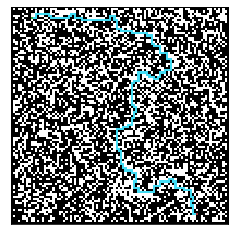

A* with euclidian


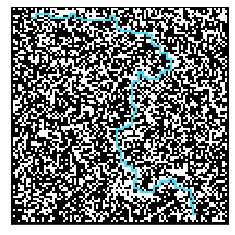

Best First with manhattan


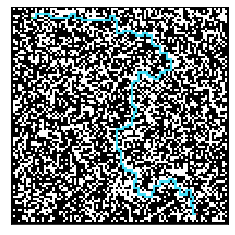

Best First with euclidian


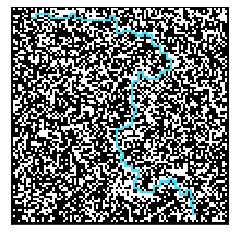

Gif of Best first with euclidian


In [ ]:
N = 100
S = (5, 9)
F = (95, 85)
p = .6

map = grid(N, S, F, p)
map.draw_map(S, F)

print("Dikstra")
pf = pathfinder(S, F, map, 1, 0)
map.draw_map(S, F, pf.get_path())

print("A* with manhattan")
pf = pathfinder(S, F, map, 1, 1)
map.draw_map(S, F, pf.get_path())

print("A* with euclidian")
pf = pathfinder(S, F, map, 1, 2)
map.draw_map(S, F, pf.get_path())

print("Best First with manhattan")
pf = pathfinder(S, F, map, 0, 1)
map.draw_map(S, F, pf.get_path())

print("Best First with euclidian")
pf = pathfinder(S, F, map, 0, 2)
map.draw_map(S, F, pf.get_path())

print("Gif of Best first with euclidian")
pf.vis.show_gif(fps = 1)

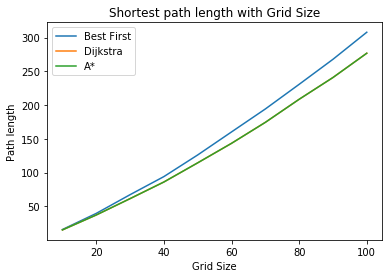

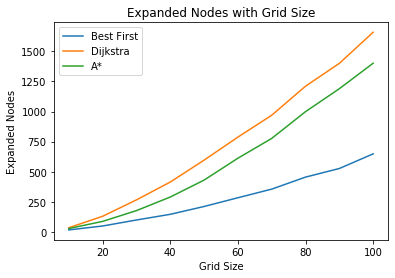

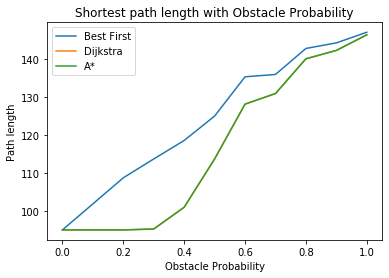

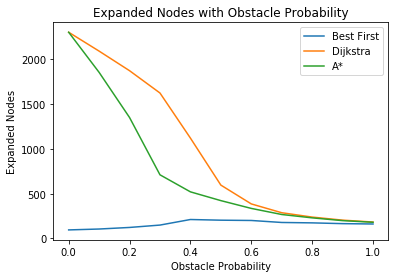

In [ ]:
avg_path_lengths_1 = np.zeros(10)
avg_path_lengths_2 = np.zeros(10)
avg_path_lengths_3 = np.zeros(10)

avg_expanded_nodes_1 = np.zeros(10)
avg_expanded_nodes_2 = np.zeros(10)
avg_expanded_nodes_3 = np.zeros(10)

p = .5
tests = list(range(10,110,10))
S = (1, 1)
j = 0

for N in tests:
    F = (N-2, N-2)
    for i in range (0, 100):
        map = grid(N, S, F, p)
        
        pf = pathfinder(S, F, map, 0, 1)
        avg_path_lengths_1[j] += len(pf.get_path())
        avg_expanded_nodes_1[j] += len(pf.get_closed_list())
        
        pf = pathfinder(S, F, map, 1, 0)
        avg_path_lengths_2[j] += len(pf.get_path())
        avg_expanded_nodes_2[j] += len(pf.get_closed_list())
        
        pf = pathfinder(S, F, map, 1, 1) 
        avg_path_lengths_3[j] += len(pf.get_path())
        avg_expanded_nodes_3[j] += len(pf.get_closed_list())   
    j += 1
    
for j in range (0,10): 
    avg_path_lengths_1[j] = avg_path_lengths_1[j] / 100
    avg_expanded_nodes_1[j] = avg_expanded_nodes_1[j] /100
    avg_path_lengths_2[j] = avg_path_lengths_2[j] / 100
    avg_expanded_nodes_2[j] = avg_expanded_nodes_2[j] /100
    avg_path_lengths_3[j] = avg_path_lengths_3[j] / 100
    avg_expanded_nodes_3[j] = avg_expanded_nodes_3[j] /100

plt.figure()
plt.xlabel('Grid Size')
plt.ylabel('Path length')
plt.title('Shortest path length with Grid Size')
plt.plot(tests,avg_path_lengths_1, label = "Best First")
plt.plot(tests,avg_path_lengths_2, label = "Dijkstra")
plt.plot(tests,avg_path_lengths_3, label = "A*")
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Grid Size')
plt.ylabel('Expanded Nodes')
plt.title('Expanded Nodes with Grid Size')
plt.plot(tests,avg_expanded_nodes_1, label = "Best First")
plt.plot(tests,avg_expanded_nodes_2, label = "Dijkstra")
plt.plot(tests,avg_expanded_nodes_3, label = "Α*")
plt.legend()
plt.show()


N = 50
tests = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
F = (48, 48)
j = 0

avg_path_lengths_1 = np.zeros(11)
avg_path_lengths_2 = np.zeros(11)
avg_path_lengths_3 = np.zeros(11)

avg_expanded_nodes_1 = np.zeros(11)
avg_expanded_nodes_2 = np.zeros(11)
avg_expanded_nodes_3 = np.zeros(11)

for p in tests:
    for i in range (0, 100):
        map = grid(N, S, F, p)
        
        pf = pathfinder(S, F, map, 0, 1)
        avg_path_lengths_1[j] += len(pf.get_path())
        avg_expanded_nodes_1[j] += len(pf.get_closed_list())
        
        pf = pathfinder(S, F, map, 1, 0)
        avg_path_lengths_2[j] += len(pf.get_path())
        avg_expanded_nodes_2[j] += len(pf.get_closed_list())
        
        pf = pathfinder(S, F, map, 1, 1) 
        avg_path_lengths_3[j] += len(pf.get_path())
        avg_expanded_nodes_3[j] += len(pf.get_closed_list())   
    j += 1
    
for j in range (0,11):    
    avg_path_lengths_1[j] = avg_path_lengths_1[j] / 100
    avg_expanded_nodes_1[j] = avg_expanded_nodes_1[j] /100
    avg_path_lengths_2[j] = avg_path_lengths_2[j] / 100
    avg_expanded_nodes_2[j] = avg_expanded_nodes_2[j] /100
    avg_path_lengths_3[j] = avg_path_lengths_3[j] / 100
    avg_expanded_nodes_3[j] = avg_expanded_nodes_3[j] /100

plt.figure()
plt.xlabel('Obstacle Probability')
plt.ylabel('Path length')
plt.title('Shortest path length with Obstacle Probability')
plt.plot(tests,avg_path_lengths_1, label = "Best First")
plt.plot(tests,avg_path_lengths_2, label = "Dijkstra")
plt.plot(tests,avg_path_lengths_3, label = "A*")
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Obstacle Probability')
plt.ylabel('Expanded Nodes')
plt.title('Expanded Nodes with Obstacle Probability')
plt.plot(tests,avg_expanded_nodes_1, label = "Best First")
plt.plot(tests,avg_expanded_nodes_2, label = "Dijkstra")
plt.plot(tests,avg_expanded_nodes_3, label = "Α*")
plt.legend()
plt.show()